# Clustering Pitcher Types to Better Predict Batter Outcomes

<br>
**Objectives**<br>
The objective of this project is to predict batter performance more accurately. Currently, the most common way of predicting a batter’s performance is by using his previous performance as a predictor for his future performance. In other words, we are asking the question: given a batter’s previous batting average (or other performance metric), what is the expected result of his next at bat? When coaches or baseball fans try to obtain a more accurate prediction for what will happen during the next at bat, they sometimes adjust the batter’s past performance based on how he fared against left-handed pitchers (LHP) and right-handed pitchers (RHP). Even more specifically, people may use a batter's past performance against that specific pitcher to predict his future performance. For example, a batter who has gone 1 for 8 against a pitcher might be predicted to have a .125 battering average against that pitcher in the future. Unfortunately, each of these techniques to predict batter performance are ineffective. Using pitcher-specific batting averages almost always leads to sample sizes too small to be significant. Overall batting averages might be accurate over the course of a season, but surely there is information about the batter/pitcher matchup to help generate a more specific prediction than using a season long average. Using adjusted batting averages against LHP and RHP seems to be a good compromise between the pitcher-specific statistics and the season long averages. In a sense, the RHP/LHP splits have assigned each hitter a batting average against LHP and a batting average against RHP. This has increased the precision with which managers have been able to make decisions, and has led to new strategies such as lefty/righty platoon hitters, and left handed relievers whose primary job it is to retire single batters whose LHP batting average is far lower than their overall batting average. Despite the success of the RHP/LHP splits, I believe that there is an even more precise way to predict future batter performance, without going all the way to a single batter to pitcher matchup and losing sufficient sample size. What if we grouped similar pitchers together, such that batters are likely to perform similarly against any pitcher within each group? If we are able to accurately divide pitchers into *types*, then each hitter could have an adjusted batting average against each *types* of pitcher, which would have a big enough sample size to be statistically significant but also be much more accurate than just looking at overall batting averages or batting averages against RHP and LHP. 

**Methodology**<br>
In 2008, MLBAM started classifying pitches into pitch types in real time in order to support their popular MLB Gameday application. This classification has improved the fan and broadcasting experience, which was the goal of creating the algorithm in the first place. The classification is known to be somewhat inaccurate, and there have been many attempts to improve it. The pitchFX data is publicly available, but because of these inaccuracies, it has been difficult to use these pitch types as the basis for further clustering. For example, it is difficult to group pitchers based on the percentage of cutters/sinkers/four-seamers/two-seamers a pitcher throws if those underlying pitch classifications aren't highly accurate. One website that has been trying to improve the accuracy of pitchFX's pitch type classifications is BrooksBaseball. They manually adjust the pitch type based on several parameters such as pitcher grips of the baseball, catcher signs, and discussion with coaches and pitchers themselves. After learning BrooksBaseball's more accurate pitching data, I wanted to see if I could accurately divide pitchers into pitcher types. Unfortunately, BrooksBaseball does not have an API or a way to easily download their data. Because of that, the first part of my project was web scraping thousands of BrooksBaseball web pages and storing the data in my own database. After that I focused on clustering the pitching data to better predict batter outcomes.

## Notebook Structure
1. Web Scrape BrooksBaseball<br>
    1.1 Extract URLs for all games<br>
    1.2 Scrape Pitching Data for each URL<br>
2. Data Manipulation<br>
    2.1 Add Pitcher Dexterity from pitchFX<br>
    2.2 Combine Similar Pitches<br>
    2.3 Take a weighted average of pitch types for each pitcher<br>
    2.4 Data Filtering<br>
    2.5 Calculate Pitch Frequencies and Velo Index for each Pitcher<br>
    2.6 Normalization<br>
3. Feature Analysis<br>
    3.1 Multicollinearity<br>
    3.2 Variance<br>
4. Cluster Analysis<br>
    4.1 Finding k through the Elbow Method<br>
    4.2 Analyzing Centers<br>

## 1. Web Scraping BrooksBaseball

First, I import the required python modules and settings.

In [1]:
# external imports 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
# from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
# from multiprocessing import Pool
import sqlite3
from IPython.core.interactiveshell import InteractiveShell

# Custom scripts
import src.constants as constants

# Notebook Settings
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

### 1.1 Extract URLs for all games

As a prequisite to running this notebook, I scraped the BrooksBaseball website to extract pitching data for the past 4 years, and loaded this data into a sqlite database (the code to web scrape are stored in the github repo). To achieve the web scraping I first generated all of the URLs that contained pitching data that I eventually wanted to scrape. I stored these urls in a table called urls.

In [2]:
# Establish connection to sqlite database
conn = sqlite3.connect(constants.BROOKS_BASEBALL_DB_NAME)

# Load urls table into memory
def load_urls_table():
    sql = "select * from urls;"
    return pd.read_sql_query(sql, conn)

urls = load_urls_table()
urls[["pitcher_id","pitcher_name","game_id","url"]].head()

,pitcher_id,pitcher_name,game_id,url
0,407890,Colby Lewis,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
1,451075,David Martinez,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
2,451596,Yovani Gallardo,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
3,464416,Yohan Pino,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
4,488786,Louis Coleman,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...


### 1.2 Scrape Pitching Data for each URL

Next, I scraped the pitching data from each url and stored it in a table called full_pitches. We only want to load data provided by "Pitch Info", as this is the system that has the impoved pitch type classifications.

In [3]:
def load_full_pitches_table():
    sql = "select * from full_pitches where type_of_data='pitch_info';"
    return pd.read_sql_query(sql, conn)

full_pitches = load_full_pitches_table()
full_pitches.head()

,pitcher_id,game_id,type_of_batters,type_of_data,pitch_type_code,pitch_type_desc,velo,h_break,v_break,count,strikes,swings,whiffs,bib,snip,lwts
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,FA,Fastball,89.0,-1.80,9.70,17.0,13.0,7.0,1.0,4.0,9.0,-1.78
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,SI,Sinker,88.8,-9.08,7.54,3.0,0.0,0.0,0.0,0.0,0.0,0.16
2,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,CH,Changeup,83.5,-10.18,7.04,2.0,0.0,0.0,0.0,0.0,0.0,0.16
3,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,CU,Curveball,75.6,8.18,-9.88,14.0,5.0,2.0,2.0,0.0,5.0,-0.42
4,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,FC,Cutter,86.1,2.58,5.66,17.0,12.0,10.0,1.0,5.0,7.0,0.27


## 2. Data Manipulation

### 2.1 Add Pitcher Dexterity from pitchFX

One data point that the BrooksBaseball webpages lacked was whether the pitcher was right handed or left handed. Before running this notebook I downloaded pitchFX's publically available data and stored in in pitchRx.db. I then pulled in this attribute into a new table called adjusted_pitches.

In [4]:
def get_p_throws_field_from_mlbgameday(full_pitches):
    mlb_gameday_conn = sqlite3.connect(constants.MLB_GAMEDAY_DB_NAME)
    sql = "select distinct pitcher as pitcher_id, p_throws from atbat;"
    adjusted_pitches = pd.merge(full_pitches, pd.read_sql_query(sql, mlb_gameday_conn))
    mlb_gameday_conn.close()
    return adjusted_pitches

adjusted_pitches = get_p_throws_field_from_mlbgameday(full_pitches)
adjusted_pitches.to_sql("adjusted_pitches", conn, if_exists="replace")
adjusted_pitches[["pitcher_id", "type_of_batters", "pitch_type_code", "count", "p_throws"]].head()

,pitcher_id,type_of_batters,pitch_type_code,count,p_throws
0,425794,LHB,FA,17.0,R
1,425794,LHB,SI,3.0,R
2,425794,LHB,CH,2.0,R
3,425794,LHB,CU,14.0,R
4,425794,LHB,FC,17.0,R


### 2.2 Combine Similar Pitches

Here is a break down of the different types of pitches in the dataset.

In [5]:
def show_pitch_type_counts():
    sql = """select pitch_type_code, pitch_type_desc, count(*) as count
             from adjusted_pitches 
             group by pitch_type_code, pitch_type_desc
             order by count desc"""
    return pd.read_sql_query(sql, conn)

show_pitch_type_counts()

,pitch_type_code,pitch_type_desc,count
0,FA,Fastball,121928
1,SL,Slider,83139
2,SI,Sinker,67595
3,CU,Curveball,59968
4,CH,Changeup,56971
5,FC,Cutter,29103
6,FS,Splitter,9794
7,FF,Four-seam Fastball,4317
8,FT,Two-seam Fastball,1822
9,CS,Slow Curve,516


Some pitch types are essentially the same pitch and should therefore be grouped together. For example, a Sinker **is** a Two-Seam Fastball. Some pitchers simply call their Two-Seam Fastball a Sinker because it has downward movement, but essentially it is still a Two-Seam Fastball. Therefore, I am grouping these two pitches together. Similarly, I am grouping "Fastball" and "Four-Seam-Fastball" together, since I believe these are variations of the same pitch. The same applies for the three variations of "Curveball".

Here are the breakdown of pitch totals after grouping similar pitches.

In [6]:
def group_similar_pitches_together(df):
    
    df.loc[(df.pitch_type_code=='SI'), 
           ['pitch_type_code', 'pitch_type_desc']] = ['FT', 'Two-seam Fastball']
    
    df.loc[(df.pitch_type_code=='FA'),
           ['pitch_type_code', 'pitch_type_desc']] = ['FF', 'Four-seam Fastball']
    
    df.loc[(df.pitch_type_code=='CS') | (df.pitch_type_code=='KC'),
           ['pitch_type_code', 'pitch_type_desc']] = ['CU', 'Curveball']
    
    return df

adjusted_pitches = group_similar_pitches_together(adjusted_pitches)
adjusted_pitches.to_sql("adjusted_pitches", conn, if_exists="replace")
show_pitch_type_counts()

,pitch_type_code,pitch_type_desc,count
0,FF,Four-seam Fastball,126245
1,SL,Slider,83139
2,FT,Two-seam Fastball,69417
3,CU,Curveball,60898
4,CH,Changeup,56971
5,FC,Cutter,29103
6,FS,Splitter,9794
7,KN,Knuckleball,339
8,FO,Forkball,10
9,SB,Screwball,9


In addition, the Knuckleball, Forkball, and Screwball are thrown so infrequently that they shouldn't get their own categories as fields and should be grouped into an *Other* category. 

In [7]:
def group_rare_pitches_into_other_category(df):
    df.loc[(df.pitch_type_code=='KN') 
         | (df.pitch_type_code=='FO')
         | (df.pitch_type_code=='SB'),
           ['pitch_type_code', 'pitch_type_desc']] = ['NA', 'Other']
    return df

    
adjusted_pitches = group_rare_pitches_into_other_category(adjusted_pitches)
adjusted_pitches.to_sql("adjusted_pitches", conn, if_exists="replace")
show_pitch_type_counts()

,pitch_type_code,pitch_type_desc,count
0,FF,Four-seam Fastball,126245
1,SL,Slider,83139
2,FT,Two-seam Fastball,69417
3,CU,Curveball,60898
4,CH,Changeup,56971
5,FC,Cutter,29103
6,FS,Splitter,9794
7,NA,Other,358


### 2.3 Take a weighted average of pitch types for each pitcher

Now that we've consolidated the pitches into their more general classifications, let's start working on the pitch statistics.

In [8]:
adjusted_pitches.head()

,pitcher_id,game_id,type_of_batters,type_of_data,pitch_type_code,pitch_type_desc,velo,h_break,v_break,count,strikes,swings,whiffs,bib,snip,lwts,p_throws
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,FF,Four-seam Fastball,89.0,-1.80,9.70,17.0,13.0,7.0,1.0,4.0,9.0,-1.78,R
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,FT,Two-seam Fastball,88.8,-9.08,7.54,3.0,0.0,0.0,0.0,0.0,0.0,0.16,R
2,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,CH,Changeup,83.5,-10.18,7.04,2.0,0.0,0.0,0.0,0.0,0.0,0.16,R
3,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,CU,Curveball,75.6,8.18,-9.88,14.0,5.0,2.0,2.0,0.0,5.0,-0.42,R
4,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,pitch_info,FC,Cutter,86.1,2.58,5.66,17.0,12.0,10.0,1.0,5.0,7.0,0.27,R


You'll notice each row in the adjusted_pitches table contains a pitch_type_code and the number of the row represents (the *count* field). For example the first row is four-seam fastball with a count of 17. This means pitcher_id 425794 had an appearance where he threw 17 fastballs, at an average velocity of 89.0 MPH. There will be many "FF" rows for that pitcher_id. 

In [9]:
def show_pitcher_id_425794(df):
    pitcher_425794 = df.loc[(df["pitcher_id"] == 425794)
                          & (df["pitch_type_code"] == "FF")]
    
    interesting_fields = pitcher_425794[["pitcher_id","game_id","type_of_batters",
                                         "pitch_type_code", "pitch_type_desc","velo","count"]]
    
    return interesting_fields.head()

show_pitcher_id_425794(adjusted_pitches)

,pitcher_id,game_id,type_of_batters,pitch_type_code,pitch_type_desc,velo,count
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,FF,Four-seam Fastball,89.0,17.0
5,425794,gid_2015_04_05_slnmlb_chnmlb_1/,RHB,FF,Four-seam Fastball,89.3,18.0
9,425794,gid_2015_04_13_milmlb_slnmlb_1/,LHB,FF,Four-seam Fastball,89.4,3.0
13,425794,gid_2015_04_13_milmlb_slnmlb_1/,RHB,FF,Four-seam Fastball,90.9,12.0
17,425794,gid_2015_04_19_cinmlb_slnmlb_1/,LHB,FF,Four-seam Fastball,89.8,6.0


In order to get an accurate view of this pitcher's typical fastball, we need to take a weighted average of all of his fastballs across all appearances. We divide this weighted average based on if the pitcher was facing RHB or LHB, as some pitchers drastically change their approach depending on the dexterity of the batter. There's also one pitcher that throws both left handed and right handed, and so we are also grouping by *p_throws*. We store those weighted averages in a tabled called weighted_totals.

In [10]:
def generate_weighted_totals(adjusted_pitches):

    # Get the total number of pitches for each pitch type for every pitcher
    sql = """select pitcher_id, p_throws, type_of_batters, pitch_type_code,
                sum(count) as pitch_type_total
                from adjusted_pitches 
                where type_of_data='pitch_info'
                and velo > 30
                group by pitcher_id, type_of_batters, pitch_type_code;
            """
    pitch_type_totals = pd.read_sql_query(sql, conn)

    # Add pitch_type_total to each pitcher for each pitch type
    join_conditions = ['pitcher_id', 'p_throws', 'type_of_batters', 'pitch_type_code']
    frequency_table = pd.merge(pitch_type_totals, adjusted_pitches, 
                               how='left', 
                               left_on=join_conditions,
                               right_on=join_conditions)
    frequency_table.to_sql("frequency_table", conn, if_exists="replace")

    # Weight each pitcher's stats by the number of pitches thrown from that appearance
    #    compared to total number of pitches thrown for that pitcher of that pitch type
    sql = """select pitcher_id, p_throws, type_of_batters, 
                pitch_type_code, pitch_type_total,
                sum(velo*(count/pitch_type_total)) as velo,
                sum(h_break*(h_break/pitch_type_total)) as h_break,
                sum(v_break*(v_break/pitch_type_total)) as v_break,
                sum(strikes*(strikes/pitch_type_total)) as strikes,
                sum(swings*(swings/pitch_type_total)) as swings,
                sum(whiffs*(whiffs/pitch_type_total)) as whiffs,
                sum(bib*(bib/pitch_type_total)) as bib,
                sum(snip*(snip/pitch_type_total)) as snip,
                sum(lwts*(lwts/pitch_type_total)) as lwts
                from frequency_table 
                group by pitcher_id, type_of_batters, 
                pitch_type_code, pitch_type_total;
            """
    weighted_totals = pd.read_sql_query(sql, conn)
    weighted_totals.to_sql("weighted_totals", conn, if_exists="replace")

    # Drop the temporary table
    cursor = conn.cursor()
    cursor.execute("drop table frequency_table;")
    cursor.close()

    # Add the total number of pitches as a column in weighted_totals table
    sql = """select pitcher_id, p_throws, type_of_batters,
                sum(pitch_type_total) as total_count
                from weighted_totals
                group by pitcher_id, type_of_batters;
            """
    total_count_table = pd.read_sql_query(sql, conn)
    join_conditions = ['pitcher_id', 'p_throws', 'type_of_batters']
    weighted_totals = pd.merge(weighted_totals, total_count_table, 
                                   how='left',
                                   left_on=join_conditions,
                                   right_on=join_conditions)
    weighted_totals.to_sql("weighted_totals", conn, if_exists="replace")

    return weighted_totals
    
    
weighted_totals = generate_weighted_totals(adjusted_pitches)
weighted_totals.head()

,pitcher_id,p_throws,type_of_batters,pitch_type_code,pitch_type_total,velo,h_break,v_break,strikes,swings,whiffs,bib,snip,lwts,total_count
0,112526,R,LHB,CH,511.0,81.478669,13.566581,5.968193,3.039139,2.410959,0.326810,0.596869,1.256360,0.125878,4868.0
1,112526,R,LHB,FC,130.0,86.343846,0.735587,16.165151,1.607692,1.138462,0.130769,0.284615,0.892308,0.078312,4868.0
2,112526,R,LHB,FF,1455.0,90.331890,2.056479,7.531251,7.659107,3.892096,0.215120,0.621306,4.452234,0.087310,4868.0
3,112526,R,LHB,FT,2616.0,87.542049,4.196863,1.254303,11.695336,5.697630,0.083716,1.694190,4.938456,0.177380,4868.0
4,112526,R,LHB,SL,156.0,81.412821,2.037888,2.906991,1.596154,1.012821,0.134615,0.288462,0.897436,0.177979,4868.0


### 2.4 Data Filtering

Next, I filtered out pitchers who had thrown fewer than 200 pitches. I'm keeping a pitcher's statistics against RHB and LHB separately, so this filtering also keeps those splits separated.

In [11]:
def filter_out_uncommon_pitchers():
    cursor = conn.cursor()
    sql = "delete from weighted_totals where total_count < 200;"
    cursor.execute(sql)
    cursor.close()
    conn.commit();

filter_out_uncommon_pitchers()

### 2.5 Calculate Pitch Frequencies and Velo Index for each Pitcher

Next, I calculated the percentage that each pitcher throws each kind of pitch by dividing number of pitches thrown for each pitch by the total number of pitches thrown. To try to quantify how fast a pitcher throws, I also created a field called *velo_index*. To generate this value I calculated each pitcher's average fastball velocity (or the average velocity of each pitcher's fastest pitch type). Again, the data against RHB and LHB is calculated separately.

In [12]:
def generate_pitch_frequencies_table():
    create_pitch_frequencies_table()
    cursor = conn.cursor()
    sql = "select distinct pitcher_id, p_throws, type_of_batters from weighted_totals;"
    cursor.execute(sql)
    rows = cursor.fetchall()
    cursor.close()

    pitch_frequencies_rows = []
    for (pitcher_id, p_throws, type_of_batters) in rows:
        row = [pitcher_id, p_throws, type_of_batters]

        # Add a column for each of these pitch_type_codes
        for pitch_type_code in ["FF", "FT", "FC", "FS", "CH", "CU", "SL", "NA"]:
            percent_for_type = get_pitch_frequency(conn, pitcher_id, p_throws, type_of_batters, pitch_type_code)
            row.append(percent_for_type)

        # Add velo index
        row.append(get_velo_index(conn, pitcher_id, p_throws, type_of_batters))

        # Add row to list
        pitch_frequencies_rows.append(row)
        
        
    sql = """insert into pitch_frequencies (pitcher_id, p_throws,
                type_of_batters, percent_ff, percent_ft, percent_fc, percent_fs,
                percent_ch, percent_cu, percent_sl, percent_na, velo_index)
                values (?,?,?,?,?,?,?,?,?,?,?,?)
            """
    cursor = conn.cursor()
    cursor.executemany(sql, pitch_frequencies_rows)
    conn.commit();
    
    return pd.read_sql_query("select * from pitch_frequencies;", conn);


def create_pitch_frequencies_table():
    cursor = conn.cursor()
    cursor.execute("drop table if exists pitch_frequencies;")
    cursor.close()
    
    sql = """ CREATE TABLE pitch_frequencies (
                pitcher_id          INT     NOT NULL,
                p_throws            TEXT    NOT NULL,
                type_of_batters     TEXT    NOT NULL,
                percent_ff          REAL    NOT NULL,
                percent_ft          REAL    NOT NULL,
                percent_fc          REAL    NOT NULL,
                percent_fs          REAL    NOT NULL,
                percent_ch          REAL    NOT NULL,
                percent_cu          REAL    NOT NULL,
                percent_sl          REAL    NOT NULL,
                percent_na          REAL    NOT NULL,
                velo_index          REAL    NOT NULL,
                PRIMARY KEY(pitcher_id, p_throws, type_of_batters)
            ); """
    cursor = conn.cursor()
    cursor.execute(sql)
    cursor.close();
    
    
def get_pitch_frequency(conn, pitcher_id, p_throws, type_of_batters, pitch_type_code):
    cursor = conn.cursor()
    sql = """select pitch_type_total/total_count 
                from weighted_totals
                where pitcher_id = ? 
                and p_throws = ? 
                and type_of_batters = ? 
                and pitch_type_code = ?
            """
    cursor.execute(sql, [pitcher_id, p_throws, type_of_batters, pitch_type_code])
    result = cursor.fetchone()
    
    if result is None:
        percent_thrown = 0
    else:
        percent_thrown = result[0]
    cursor.close()
    
    return percent_thrown


def get_velo_index(conn, pitcher_id, p_throws, type_of_batters):
    cursor = conn.cursor()
    sql = """select max(velo_index) 
                from (select avg(velo) as velo_index 
                        from weighted_totals
                        where pitcher_id = ?
                        and p_throws = ? 
                        and type_of_batters = ?
                        group by pitch_type_code, pitcher_id,
                        p_throws, type_of_batters
                     );
            """
    cursor.execute(sql, [pitcher_id, p_throws, type_of_batters])
    velo_index = cursor.fetchone()[0]
    cursor.close()
    return velo_index


pitch_frequencies = generate_pitch_frequencies_table()
pitch_frequencies.head()

,pitcher_id,p_throws,type_of_batters,percent_ff,percent_ft,percent_fc,percent_fs,percent_ch,percent_cu,percent_sl,percent_na,velo_index
0,112526,R,LHB,0.298891,0.537387,0.026705,0.0,0.104971,0.000000,0.032046,0.0,90.331890
1,112526,R,RHB,0.167743,0.661486,0.009084,0.0,0.049657,0.000202,0.111829,0.0,90.455836
2,115629,R,LHB,0.009772,0.674267,0.000000,0.0,0.104235,0.019544,0.192182,0.0,93.561836
3,115629,R,RHB,0.033835,0.785714,0.000000,0.0,0.033835,0.007519,0.139098,0.0,94.147847
4,150116,L,RHB,0.165485,0.321513,0.222222,0.0,0.125296,0.163121,0.002364,0.0,89.437143


### 2.6 Normalization

Next I normalize the table so that the values can be clustered propertly.

In [13]:
def normalize_values(df):
    fields_to_scale = ["percent_ff", "percent_ft", "percent_fc",
                       "percent_fs", "percent_ch", "percent_cu",
                       "percent_sl", "percent_na", "velo_index"]
    
    df[fields_to_scale] = MinMaxScaler().fit_transform(df[fields_to_scale])
    df.to_sql("normalized", conn, if_exists="replace")
    conn.commit()
    return df

normalized = normalize_values(pitch_frequencies)
normalized.head()

,pitcher_id,p_throws,type_of_batters,percent_ff,percent_ft,percent_fc,percent_fs,percent_ch,percent_cu,percent_sl,percent_na,velo_index
0,112526,R,LHB,0.326118,0.576940,0.030300,0.0,0.201868,0.000000,0.044781,0.0,0.806245
1,112526,R,RHB,0.183024,0.710173,0.010306,0.0,0.095494,0.000371,0.156269,0.0,0.808331
2,115629,R,LHB,0.010662,0.723895,0.000000,0.0,0.200451,0.035901,0.268555,0.0,0.860598
3,115629,R,RHB,0.036917,0.843545,0.000000,0.0,0.065067,0.013811,0.194375,0.0,0.870459
4,150116,L,RHB,0.180559,0.345177,0.252137,0.0,0.240953,0.299638,0.003304,0.0,0.791189


## 3. Feature Analysis

Now that the data is ready for analysis, I divide the data into 4 sections:
1. RHP vs. RHB
2. RHP vs. LHB
3. LHP vs. RHB
4. LHP vs. LHP

In [14]:
def generate_data_sections():
    sections = []
    matchups = (["R","RHB"],["R","LHB"],["L","RHB"],["L","LHB"])
    for (p_throws, type_of_batters) in matchups:
        
        sql = """select * from normalized
                    where p_throws='{}' 
                    and type_of_batters='{}';
                """.format(p_throws, type_of_batters)
                
        data_section = {"p_throws": p_throws,
                        "type_of_batters": type_of_batters,
                        "df": pd.read_sql_query(sql, conn)}
        
        sections.append(data_section)
        
    return sections
    
    
data_sections = generate_data_sections()

### 3.1 Multicollinearity 

To vizualize how varibles are related to each other I plotted a correlation matrix for each section of data. 

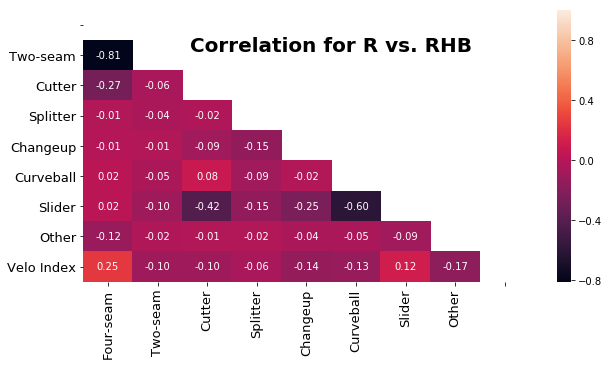

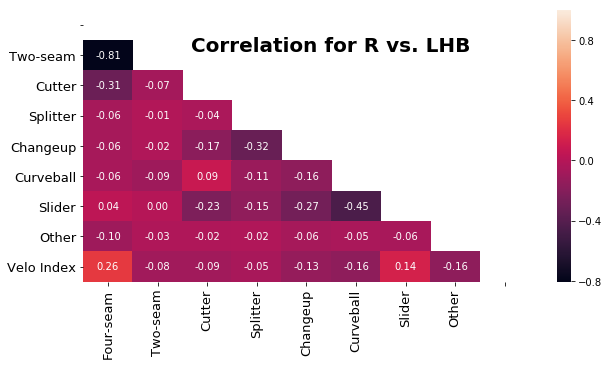

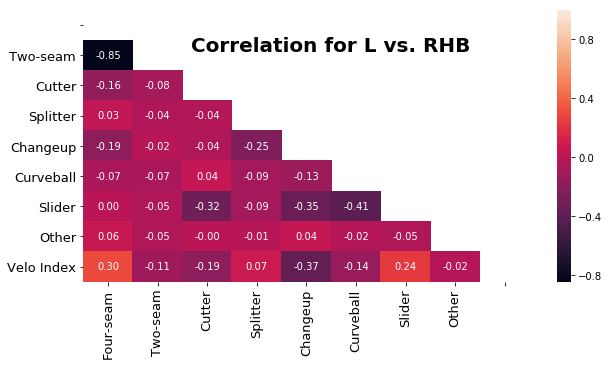

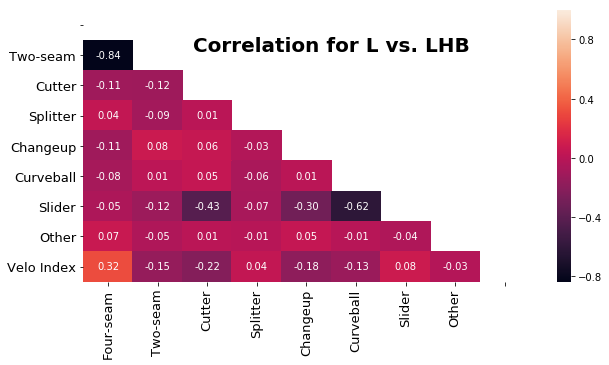

In [15]:
def plot_correlation_matrix_grid(data_sections):
    for data_section in data_sections:       
        
        # Get data from data_section
        p_throws = data_section["p_throws"]
        type_of_batters = data_section["type_of_batters"]
        fields_to_drop = ["pitcher_id", "p_throws", "type_of_batters", "index"]
        df = data_section["df"].drop(fields_to_drop, axis=1)
        corr = df.corr()
        
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        # generate heatmap
        plt.figure(figsize=(10, 5))
        fig = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f")
        
        # Set labels and title
        labels = ["Four-seam", "Two-seam", "Cutter",
                  "Splitter", "Changeup", "Curveball",
                  "Slider", "Other", "Velo Index"]
        fig.set_xticklabels(labels[:-1], rotation=90, fontsize=13)
        labels[0] = ""
        fig.set_yticklabels(labels, fontsize=13)
        title = "Correlation for {} vs. {}".format(p_throws, type_of_batters)
        fig.text(x=5, y=1.5, s=title, fontsize=20,
                 weight='bold', ha='center', va='bottom')

        # Display heatmap
        plt.show();


plot_correlation_matrix_grid(data_sections)

There are several themes across each of these correlation matrices. The strongest correlation (for positive or negative) is a negative correlation between four-seamers (FF) and two-seamers (FT). This makes sense because these two pitches are often substitutes for each other. Along the same lines, cutters (FC) are negatively correlated with four-semears too. Another strong correlation is a negative relationship between sliders (SL) and curveballs (CU), becuase pitchers usually throw one or the other but not both. Velo_index is positively correlated with four-seamers and sliders, both pitches that many power pitchers throw. 

### 3.2 Variance

Next, for each dataset (R vs. RHB, R vs. LHB, etc.) I calculated the variance for every variable. Very low variance can be problematic as they have little predictive power while affecting the other more influential variables.

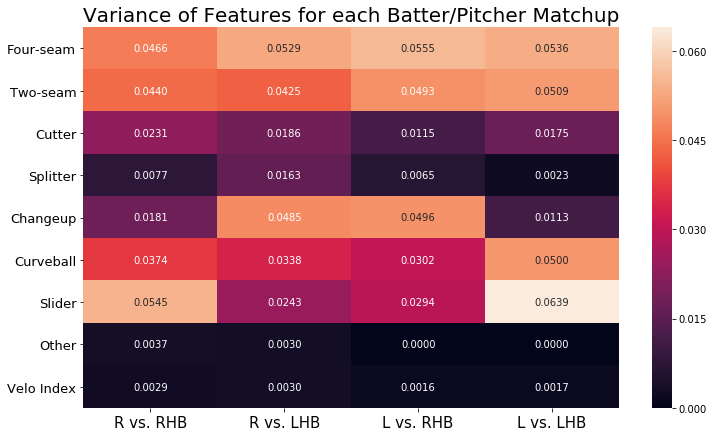

In [16]:
def analyze_variance_threshold(data_sections):
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    variance_list = []
    titles = []
    for section in data_sections:
        df = section["df"]
        p_throws = section["p_throws"]
        type_of_batters = section["type_of_batters"]
        
        fields_to_drop = ["pitcher_id", "p_throws", "type_of_batters", "index"]
        df = section["df"].drop(fields_to_drop, axis=1)
        variance_list.append(df.var())
        titles.append("{} vs. {}".format(p_throws, type_of_batters))
        
    return pd.concat(variance_list, axis=1, keys=titles)


def plot_variance_heatmap(df):
    threshold = 0.01
    plt.figure(figsize=(12, 7))
    g = sns.heatmap(df, annot=True, fmt=".4f")
    loc, labels = plt.xticks()
    g.set_xticklabels(labels, fontsize=15)
    ylabels = ["Four-seam", "Two-seam", "Cutter",
               "Splitter", "Changeup","Curveball",
               "Slider", "Other", "Velo Index"]
    g.set_yticklabels(ylabels, fontsize=13)
    g.set_title("Variance of Features for each Batter/Pitcher Matchup", fontsize=20)


variance = analyze_variance_threshold(data_sections)
plot_variance_heatmap(variance)

Each column represents the variance for each variable for a specific cut of the data. Fore example, the first column shows the variances for each variable within the R vs. RHB dataset.

We can learn a lot of valuable information from this heatmap. There's a lot of variance for four-seamers (FF) and two-seamers (FT), which could make sense if pitchers are choosing one type of fastball to throw. There's also a lot of variance for sliders (SL) and curveballs (CU). One interesting finding is that changeups (CH) have much more variance for R vs. LHB and L vs. RHB than for R vs. RHB and L vs. LHB. For some reason there's a big variance in how many changeups pitchers throw to batters of the opposite side.

Splitters (FS) and cutters (FC) have less variance, and the Othe category (NA) has almost no variance, because most pitchers throw zero Other pitches. These variables could potentially be removed from the model. 

The fact that velo_index has so little variance is problematic. Intuitively we know that how hard a pitcher throws an important feature when classying pitchers. The problem is that the difference between a hard throwing pitcher and an average pitcher could be as little as 3 MPH. To improve the variance of velo_index, I need to widen the gap between the velo values.

## 4. Cluster Analysis

### 4.1 Finding K using the Elbow Method

I'm using the elbow method to determine the optimal number of clusters. To do this I calculated the sum of squared distances for each combination of k between 1 and 15. The KneeLocator library helps us detect the point where the slope of the line starts to decrease less rapidly. 

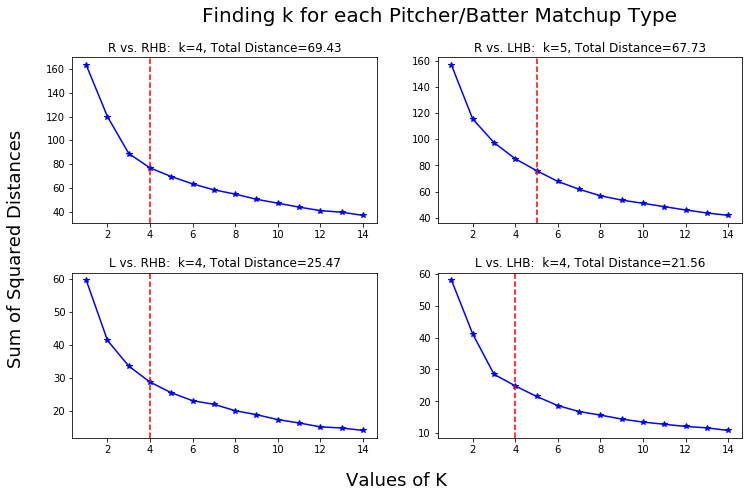

In [17]:
def plot_sum_of_squared_distances_and_get_optimal_k(data_sections):
    fig, axes = plt.subplots(nrows=2, ncols=2,
                             sharex=False,
                             sharey=False,
                             figsize=(12, 7))
    
    for i, ax in enumerate(axes.flat):
        df = data_sections[i]["df"]
        p_throws = data_sections[i]["p_throws"]
        type_of_batters = data_sections[i]["type_of_batters"]

        fields_to_drop = ["pitcher_id", "p_throws", "type_of_batters", "index"]
        df = df.drop(fields_to_drop, axis=1)
        
        sum_of_squared_distances = []
        k_range = range(1, 15)
        for k in k_range:
            km = KMeans(n_clusters=k)
            km = km.fit(df)
            sum_of_squared_distances.append(km.inertia_)
            
        ax.plot(k_range, sum_of_squared_distances, 'b*-')

        # Draw KneeLocator line
        y = sum_of_squared_distances
        x = range(1, len(y) + 1)
        kn = KneeLocator(x, y, curve='convex', direction='decreasing')
        ax.axvline(x=kn.knee, ymin=0.0, ymax=1.0, color='r', linestyle='--')
        
        # Set optimal_k in data_sections dictionary
        data_sections[i]["optimal_k"] = kn.knee
        
        # Set title
        distance = sum_of_squared_distances[kn.knee].round(2)
        ax.set_title("{} vs. {}:  k={}, Total Distance={}"
                     .format(p_throws, type_of_batters, kn.knee, distance))   
        
    fig.subplots_adjust(hspace=.3)
    fig.suptitle("Finding k for each Pitcher/Batter Matchup Type",
                 x=.55, fontsize=20)
    fig.text(0.5, 0.04, 'Values of K', ha='center',
             va='center', fontsize=18)
    fig.text(0.06, 0.5, 'Sum of Squared Distances', ha='center',
             va='center', rotation='vertical', fontsize=18)
    plt.show();
    return data_sections

    
data_sections = plot_sum_of_squared_distances_and_get_optimal_k(data_sections)

Based on the sum of squared distances, it looks like the optimal number of clusters is 4 for all sections of data except R. vs. LHB where the optimal number is 5. Interestingly, the sum of squared distances is much lower for left handed pitchers than it is for right handed pitchers. That could be because there are far fewer left handed pitchers, so kmeans is having an easier time clustering the pitchers into groups.

### 4.2 Analyzing Cluster Centers

Here we can see the breakdown of each cluster center.

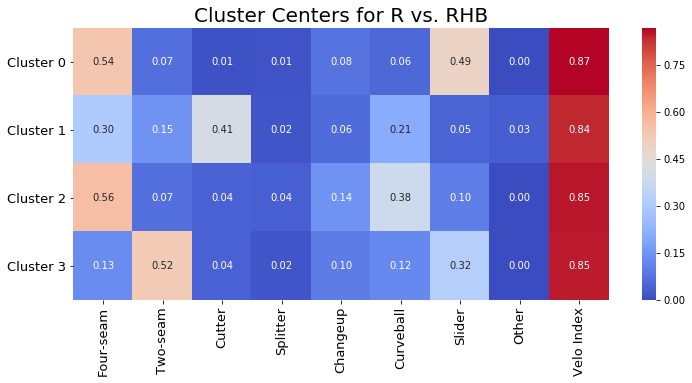

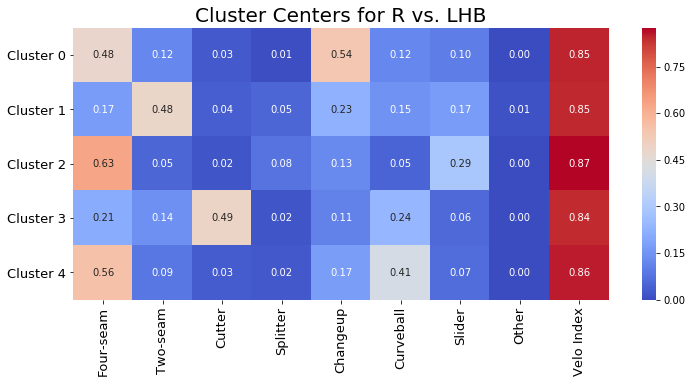

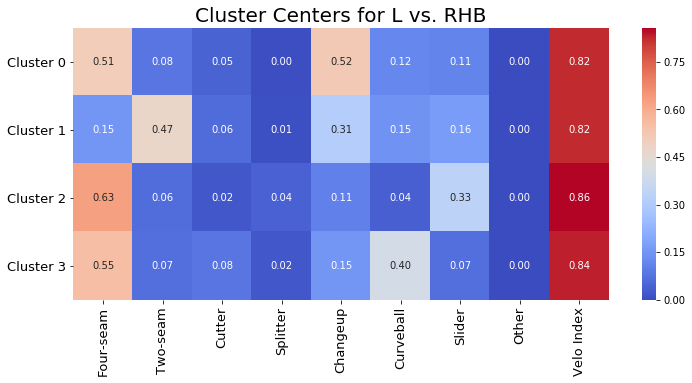

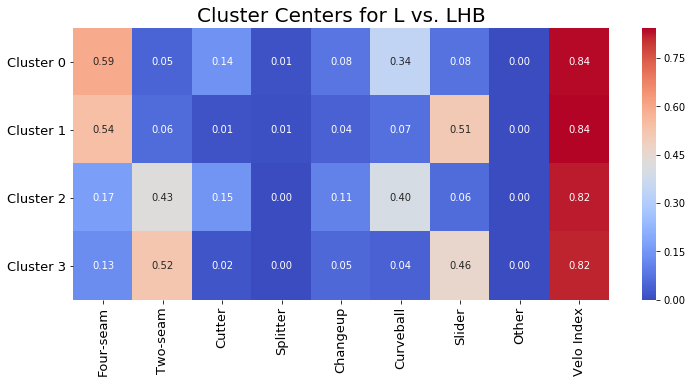

In [18]:
def analyze_cluster_centers(data_sections):
    for data_section in data_sections:
        p_throws = data_section["p_throws"]
        type_of_batters = data_section["type_of_batters"]
        df = data_section["df"]
        
        fields_to_drop = ["pitcher_id", "p_throws", "type_of_batters", "index"]
        df = df.drop(fields_to_drop, axis=1)
        k = data_section["optimal_k"]

        # Run kmeans
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)

        # Add cluster as a column
        df['cluster'] = kmeans.labels_
                
        # Group pitchers by their cluster
        grouped = df.groupby(['cluster'], sort=True).mean()
   
        # generate heatmap
        plt.figure(figsize=(12, 5))
        fig = sns.heatmap(grouped, annot=True, fmt=".2f", cmap='coolwarm')
                
        # Set labels and title
        xlabels = ["Four-seam", "Two-seam", "Cutter",
                   "Splitter", "Changeup", "Curveball",
                   "Slider", "Other", "Velo Index"]
        fig.set_xticklabels(xlabels, rotation=90, fontsize=13)
        ylabels = ["Cluster {}".format(i) for i in range(0, k)]
        fig.set_yticklabels(ylabels, rotation=0, fontsize=13)
        fig.set_ylabel('')    
        plt.title("Cluster Centers for {} vs. {}"
                  .format(p_throws, type_of_batters), fontsize=20)
        
        # Display heatmap
        plt.show();

    
analyze_cluster_centers(data_sections)

Close the connection to the sqlite database

In [19]:
conn.close()